# TRAINING A CLASSIFIER

**Source**: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py

## What about Data

Generally, when you have to deal with image, text, audio or video data, you can use standard python packages that load data into a numpy array. Then you can convert this array into a `torch.*Tensor.`

- For images, packages such as Pillow, OpenCV are useful
- For audio, packages such as scipy and librosa
- For text, either raw Python or Cython based loading, or NLTK and SpaCy are useful

For this tutorial, we will use the CIFA10 dataset.It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

<img src="https://pytorch.org/tutorials/_images/cifar10.png">

## Training an image classifier
We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using torchvision
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

### 1. Loading and normalizing CIFAR10

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1]

In [2]:
transform = transforms.Compose(
                            [transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [3]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                       download=True, transform=transform)

Extracting ./data/cifar-10-python.tar.gz to ./data


In [4]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                         shuffle=True, num_workers=2)

In [5]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

Files already downloaded and verified


In [6]:
testloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                         shuffle=True, num_workers=2)

In [7]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Show some example of data:

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img/2 + 0.5 #unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

In [9]:
#Get some random training images
dataiter = iter(trainloader)

In [10]:
images , labels = dataiter.next()

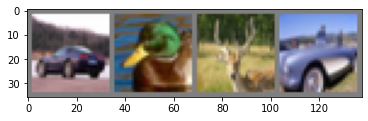

     car     bird     deer      car


In [14]:
#show images
imshow(torchvision.utils.make_grid(images))
#print labels
print(' '.join('%8s' %classes[labels[j]] for j in range(4)))

### 2. Define a Convolutional Neural Network

Copy the neural network from the Neural Networks [section before](http://localhost:8888/notebooks/deep_learning_with_Pytorch_60_minute_blitz/Neural%20Networks.ipynb) and modify it to take 3-channel images (instead of 1-channel images as it was defined).

In [15]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 6*6 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x    

In [16]:
net = Net()

In [17]:
net

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

### 3. Define a Loss function and optimizer

In [18]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 4. Train the network

In [22]:
for epoch in range(2): #loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        #get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        #zero the parameter gradients
        optimizer.zero_grad()
        
        #forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        #print statistics
        running_loss += loss.item()
        if i% 2000 == 1999: #print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %(epoch+1, i+1, running_loss/2000))
            running_loss = 0.0
            
    print("Finished training")

[1,  2000] loss: 2.177
[1,  4000] loss: 1.845
[1,  6000] loss: 1.676
[1,  8000] loss: 1.579
[1, 10000] loss: 1.509
[1, 12000] loss: 1.454
Finished training
[2,  2000] loss: 1.403
[2,  4000] loss: 1.382
[2,  6000] loss: 1.349
[2,  8000] loss: 1.316
[2, 10000] loss: 1.323
[2, 12000] loss: 1.297
Finished training


Save trained model:

In [23]:
PATH = './cifar_net_pth'
torch.save(net.state_dict(), PATH)

### 5. Test the network on the test data

We have trained the network for 2 passes over the training dataset. But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network outputs, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.

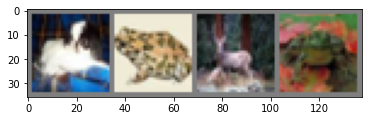

Ground Truth:    dog  frog  deer  frog


In [37]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('Ground Truth: ', ' '.join('%5s' %classes[labels[j]] for j in range(4)))

In [38]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [39]:
outputs = net(images)

In [40]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    dog  frog horse  frog


Accuraccy:

In [43]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('Accuracy of the network on the 1000 test images: %d %%' %(
        100*correct/total))

Accuracy of the network on the 1000 test images: 55 %


Accuracy for each class:


In [44]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 62 %
Accuracy of   car : 63 %
Accuracy of  bird : 32 %
Accuracy of   cat : 34 %
Accuracy of  deer : 40 %
Accuracy of   dog : 64 %
Accuracy of  frog : 58 %
Accuracy of horse : 70 %
Accuracy of  ship : 74 %
Accuracy of truck : 50 %
